In [1]:
import sys
sys.path.append( '../' )

In [405]:
import numpy as np
import cs_vqe as c
import ast
import os

import scipy as sp
import matplotlib.pyplot as plt

In [205]:
from openfermion import qubit_operator_sparse
from quchem.Misc_functions import conversion_scripts as conv_scr
from openfermion.ops import QubitOperator

In [464]:
ham = {
 # noncon
 'ZII':0.1,
 'IXI':0.3,
 'IYI':0.1,
 'IZX':0.2,
 'IZY':0.7,
 'IZZ':0.9,
 'ZXI':0.2,
 'ZYI':0.1,
 'ZZX':0.8,
 'ZZY':0.7,
 'ZZZ':0.6,

 # con
 'IIX':0.4,
 'IIY':0.6,
 'IIZ':0.7,
      }
n_qubits = 3

In [5]:
len(ham)

14

In [465]:
ham_full_open_F = conv_scr.Get_Openfermion_Hamiltonian(ham)

# Get non-contextual H

In [466]:
nonH_guesses = c.greedy_dfs(ham, 10, criterion='weight') # criterion='weight' // 'size'

nonH = max(nonH_guesses, key=lambda x:len(x)) # largest nonCon part found by dfs alg

In [468]:
nonCon_H = {}
Con_H = {}

for P in ham:
    if P in nonH:
        nonCon_H[P]=ham[P]
    else:
        Con_H[P]=ham[P]

        
import pprint

pprint.pprint(Con_H)
print()
pprint.pprint(nonCon_H)

{'IXI': 0.3, 'IYI': 0.1, 'ZXI': 0.2, 'ZYI': 0.1}

{'IIX': 0.4,
 'IIY': 0.6,
 'IIZ': 0.7,
 'IZX': 0.2,
 'IZY': 0.7,
 'IZZ': 0.9,
 'ZII': 0.1,
 'ZZX': 0.8,
 'ZZY': 0.7,
 'ZZZ': 0.6}


In [477]:
Con_H = {'IXI': 0.3,
         'IYI': 0.1,
         'ZXI': 0.2,
         'ZYI': 0.1
        }

nonCon_H = {
             'IIX': 0.4,
             'IIY': 0.6,
             'IIZ': 0.7,
             'IZX': 0.2,
             'IZY': 0.7,
             'IZZ': 0.9,
             'ZII': 0.1,
             'ZZX': 0.8,
             'ZZY': 0.7,
             'ZZZ': 0.6
}

Split into:

$$H = H_{c} + H_{nc}$$

## Testing contextuality

In [478]:
print('Is NONcontextual correct:', not c.contextualQ_ham(nonCon_H))

Is NONcontextual correct: True


# Classical part of problem!

Take $H_{nc}$ and split into:
- $Z$ = operators that completely comute with all operators in $S$
- $T$ = remaining operators in $S$
    - where $S = Z \cup T$  and $S$ is set of Pauli operators in $H_{nc}$
    
    
- We then split the set $T$ into cliques $C_{1}, C_{2}, ... , C_{|T|}$
    - all ops in a clique commute
    - ops between cliques anti-commute!

In [479]:
bool_flag, Z_list, T_list = c.contextualQ(list(nonCon_H.keys()), verbose=True)

In [480]:
Z_list

['ZII']

## Get quasi model

First we define

- $C_{i1}$ = first Pauli in each $C_{i}$ set
- $A_{ij} = C_{ij}C_{1i}$


- $G^{prime} = \{1 P_{i} \;| \; i=1,2,...,|Z| \}$
    - aka all the completely commuting terms with coefficients set to +1!

- We define G to be an independent set of $G^{prime}$
    - where $G \subseteq G^{prime}$


In [474]:
G_list, Ci1_list, all_mappings = c.quasi_model(nonCon_H)

In [482]:
print('non-independent Z list:', Z_list)
print('G (independent) Z list:', G_list)

non-independent Z list: ['ZII']
G (independent) Z list: ['ZII', 'IZI']


In [483]:
print('all T list (dependent):', T_list)
print('all Ci1 terms (independent):', Ci1_list)

# T list can be built from Ci1 terms AND some combination of G_list!

all T list (dependent): ['IIX', 'IIY', 'IIZ', 'IZX', 'IZY', 'IZZ', 'ZZX', 'ZZY', 'ZZZ']
all Ci1 terms (independent): ['IIZ', 'IIY', 'IIX']


$$R = G \cup \{ C_{i1} \;| \; i=1,2,...,N \}$$

In [271]:
# Assemble all the mappings from terms in the Hamiltonian to their products in R:
all_mappings

{'IIX': [[], ['IIX'], 1],
 'IIY': [[], ['IIY'], 1],
 'IIZ': [[], ['IIZ'], 1],
 'IZX': [['IZI'], ['IIX'], 1],
 'IZY': [['IZI'], ['IIY'], 1],
 'IZZ': [['IZI'], ['IIZ'], 1],
 'ZII': [['ZII'], [], 1],
 'ZZX': [['ZII', 'IZI'], ['IIX'], 1],
 'ZZY': [['ZII', 'IZI'], ['IIY'], 1],
 'ZZZ': [['ZII', 'IZI'], ['IIZ'], 1]}

Overall $R$ is basically reduced non-contextual set
- where everything in original non-contextual set can be found by **inference!**

In [272]:
Ci1_list

['IIX', 'IIY', 'IIZ']

# Function form

$$R = G \cup \{ C_{i1} \;| \; i=1,2,...,N \}$$

- note q to do with $G$
- note r to do with $C_{i1}$

In [273]:
model = [G_list, Ci1_list, all_mappings]
fn_form = c.energy_function_form(nonCon_H, model)

In [274]:
fn_form

[2,
 3,
 [[0.4, [], [0], 'IIX'],
  [0.6, [], [1], 'IIY'],
  [0.7, [], [2], 'IIZ'],
  [0.2, [1], [0], 'IZX'],
  [0.7, [1], [1], 'IZY'],
  [0.9, [1], [2], 'IZZ'],
  [0.1, [0], [], 'ZII'],
  [0.8, [0, 1], [0], 'ZZX'],
  [0.7, [0, 1], [1], 'ZZY'],
  [0.6, [0, 1], [2], 'ZZZ']]]

In [275]:
Energy_function = c.energy_function(fn_form)

In [276]:
model = [G_list, Ci1_list, all_mappings]

lowest_eigenvalue, ground_state_params, model_copy, fn_form_copy,  = c.find_gs_noncon(nonCon_H,
               method = 'differential_evolution',
               model=model,
               fn_form=fn_form) # returns:  best + [model, fn_form]

print(lowest_eigenvalue)
print(ground_state_params)

-3.186335345030996
[[1, 1], [-0.4260064364450332, -0.6085806359213588, -0.6694386646205599]]


In [277]:
## check
Energy_function(*ground_state_params[0],*ground_state_params[1]) == lowest_eigenvalue

True

In [278]:
sum(np.abs([-0.426, -0.609, -0.669])**2)

0.9999180000000001

# Now need to rotate Hamiltonian!

We now have non contextual ground state: $(\vec{q}, \vec{r})$

To do this we first rotate each $G_{j}$ and $\mathcal{A} = \sum_{i=1}^{N} r_{i}A_{i}$:

In [279]:
for r_i, A_i in zip(ground_state_params[1],Ci1_list):
    print(r_i, A_i)

-0.4260064364450332 IIX
-0.6085806359213588 IIY
-0.6694386646205599 IIZ


In [280]:
model = [G_list, Ci1_list, all_mappings]

print(G_list) # G_j terms!
print(Ci1_list) # mathcal(A)

['ZII', 'IZI']
['IIX', 'IIY', 'IIZ']


to SINGLE QUBIT pauli Z operators!

- to map the operators in $G$ to single qubit Pauli operators, we use $\frac{\pi}{2}$ rotations!

- note $\mathcal{A}$ is an anti-commuting set... therefore we can use $N-1$ rotations as in unitary partitioning's sequence of rotations to do this!
    - $R^{\dagger}\mathcal{A} R = \text{single Pauli op}$

# Rotate full Hamiltonian to basis with diagonal noncontextual generators!

function ```diagonalize_epistemic```:
1. first if else statement:
    - if cliques present:
        - first maps A to single Pauli operator (if cliques present)
        - then rotates to diagonlize G union with single Pauli opator of A (hence GuA name!)
    - else if NO cliques present:
        - gets rotations to diagonlize G
        
     - these rotations make up GuA term in code!
2. NEXT code loops over terms in GuA (denoted as g in code)
    - if g is not a single qubit $Z$:
        - code generates code to rotate operator to make g diagonal (rotations)
        - then constructs map of g to single Z (J rotation)
    - Note R is applied to GuA
    
    
#########
- Note rotations are given in Appendix A of https://arxiv.org/pdf/2011.10027.pdf
    - First code checks if g op in GuA is diagonal
        - if so then needs to apply "K" rotation (involving $Y$ and $I$ operators (see pg 11 top) to make it NOT diagononal
    - now operator will be diagnoal!
    - next generate "J" rotation
        - turns non-diagonal operator into a single qubit $Z$ operator!

In [249]:
# Get sequence of rotations requried to diagonalize the generators for the noncontextual ground state!

Rotations_list, diagonalized_generators_GuA, eigen_vals_nonC_ground_state_GuA_ops = c.diagonalize_epistemic(model,
                                                                                                            fn_form,
                                                                                                            ground_state_params)

In [463]:
Ci1_list

['IIX', 'IIY', 'IIZ']

In [282]:
script_A_dict = dict(zip(Ci1_list, ground_state_params[1]))

qubit_script_A_list = conv_scr.Get_Openfermion_Hamiltonian(script_A_dict)

qubit_script_A_list

-0.4260064364450332 [X2] +
-0.6085806359213588 [Y2] +
-0.6694386646205599 [Z2]

In [288]:
from openfermion import get_sparse_operator
from scipy.linalg import expm
X_sk_Op = QubitOperator('X0 Y1')
theta=0.76
mat = get_sparse_operator(X_sk_Op).todense()
np.allclose(expm(-1j*theta/2* mat),
            np.cos(theta/2)*np.eye(mat.shape[1]) - 1j*np.sin(theta/2)*mat)

True

In [289]:
from quchem.Unitary_Partitioning.Unitary_partitioning_Seq_Rot import Get_Xsk_op_list
S_index=0
N_Qubits=n_qubits
check_reduction = True
X_sk_theta_sk_list, normalised_FULL_set, Ps, gamma_l = Get_Xsk_op_list(qubit_script_A_list,
                                                                        S_index,
                                                                        N_Qubits,
                                                                        check_reduction=check_reduction,
                                                                        atol=1e-8,
                                                                        rtol=1e-05)
X_sk_theta_sk_list

R_sk_OP_list = []
for X_sk_Op, theta_sk in X_sk_theta_sk_list:
    op = np.cos(theta_sk / 2) * QubitOperator('') -1j*np.sin(theta_sk / 2) * X_sk_Op
    R_sk_OP_list.append(op)
    print(X_sk_Op, theta_sk/2)
    
R_sk_OP_list

(-1+0j) [Z2] 2.0508315127948626
(1-0j) [Y2] -0.3667264482598517


[-0.4618103850589453 [] +
 0.8869786740681586j [Z2],
 0.9335061148471899 [] +
 0.358561478052098j [Y2]]

In [254]:
Ps

1 [X2]

In [290]:
single_qubit_rot_op_list = []

for ang_op in Rotations_list[len(X_sk_theta_sk_list):]:
    angle = ang_op[0]
    op = ang_op[1]
    theta = np.pi/2
    P = QubitOperator((' ').join([f'{sigma_i}{q_i}' for q_i, sigma_i in enumerate(op) if sigma_i != 'I']))
    R_op = np.cos(theta / 2) * QubitOperator('') -1j*np.sin(theta / 2) * P
    print(theta, angle, P)
    
    single_qubit_rot_op_list.append(R_op)
single_qubit_rot_op_list

[]

In [291]:
from functools import reduce
# print(Rotations_list)

U_dag_op_full_SeqRot = [*R_sk_OP_list, *single_qubit_rot_op_list]
U_dag_op_full_SeqRot_OPERATOR  = reduce(lambda x,y: x*y, U_dag_op_full_SeqRot) 

In [292]:
U_dag_op_full_SeqRot

[-0.4618103850589453 [] +
 0.8869786740681586j [Z2],
 0.9335061148471899 [] +
 0.358561478052098j [Y2]]

In [293]:
from copy import deepcopy

ham_full = list(deepcopy(ham_full_open_F))
counter=0
for q_op in qubit_script_A_list:
    for ind in range(len(ham_full)):
        op = ham_full[ind]
        if op*q_op==q_op*op:
            continue
        else:
            ham_full[ind] = q_op*op
            counter+=1
counter

18

In [294]:
14 + 14*len(list(qubit_script_A_list))

56

In [295]:
from openfermion import hermitian_conjugated

H_subspace_SEQROT = U_dag_op_full_SeqRot_OPERATOR * ham_full_open_F * hermitian_conjugated(U_dag_op_full_SeqRot_OPERATOR)

len(list(H_subspace_SEQROT))

32

In [309]:
H_subspace_SEQROT

(0.10000000000000002+0j) [Z0] +
(0.20000000000000004+0j) [Z0 X1] +
(0.10000000000000002+0j) [Z0 Y1] +
(-0.6839287809152911+0j) [Z0 Z1 X2] +
(-0.24361444275731284+0j) [Z0 Z1 Y2] +
(0.9812713314449617+0j) [Z0 Z1 Z2] +
(0.30000000000000004+0j) [X1] +
(0.10000000000000002+0j) [Y1] +
(-0.31315556082056084+0j) [Z1 X2] +
(-0.7732904822811322+0j) [Z1 Y2] +
(0.8024683325468829+0j) [Z1 Z2] +
(-0.3932132276592766+0j) [X2] +
(-0.48454301613251594+0j) [Y2] +
(0.7877825988881568+0j) [Z2]

In [296]:
from scipy.linalg import eigh
ham_red_sparse = qubit_operator_sparse(H_subspace_SEQROT, n_qubits=n_qubits)
eig_values_SEQROT, eig_vectors_SEQROT = eigh(ham_red_sparse.todense()) # NOT sparse!
eig_values_SEQROT

array([-3.24905452, -1.39605624, -1.24306881, -1.22260333,  1.02260333,
        1.19605624,  1.44306881,  3.44905452])

In [297]:
H_full_mat = qubit_operator_sparse(ham_full_open_F, n_qubits=n_qubits)
eig_values, eig_vectors = eigh(H_full_mat.todense()) # NOT sparse!
eig_values

array([-3.24905452, -1.39605624, -1.24306881, -1.22260333,  1.02260333,
        1.19605624,  1.44306881,  3.44905452])

In [298]:
np.linalg.norm(eig_values_SEQROT - eig_values)

3.0847422370805075e-15

# NEW LCU method

In [299]:
import quchem.Unitary_Partitioning.Unitary_partitioning_LCU_method as LCU_UP 

N_index=0
N_Qubits=n_qubits
R_linear_comb_list, Pn, gamma_l  = LCU_UP.Get_R_op_list(qubit_script_A_list, 
                                                 N_index, 
                                                 N_Qubits, 
                                                 check_reduction=False, 
                                                 atol=1e-8,
                                                 rtol=1e-05)
Pn

1 [X2]

In [301]:
R_linear_comb_list

[0.5357208058097832 [],
 (-0-0.5680016804662293j) [Z2],
 0.6248018159465095j [Y2]]

In [302]:
import cs_vqe_with_LCU as c_LCU
check_reduction=True
N_Qubits= n_qubits

R_LCU, Rotations_list, diagonalized_generators_GuA, eigen_vals_nonC_ground_state_GuA_ops = c_LCU.diagonalize_epistemic_LCU(
                                      model,
                                      fn_form,
                                      ground_state_params,
                                      check_reduction=True)
R_LCU

[0.5357208058097832 [], -0.5680016804662293j [Z2], 0.6248018159465095j [Y2]]

In [303]:
R_LCU_op = reduce(lambda x,y: x+y, R_LCU) 

In [304]:
U_dag_op_full_LCU = [R_LCU_op, *single_qubit_rot_op_list]
U_dag_op_full_LCU_OPERATOR  = reduce(lambda x,y: x*y, U_dag_op_full_LCU) 

In [305]:
H_subspace_LCU = U_dag_op_full_LCU_OPERATOR * ham_full_open_F * hermitian_conjugated(U_dag_op_full_LCU_OPERATOR)
len(list(H_subspace_LCU))

32

In [306]:
ham_red_sparse = qubit_operator_sparse(H_subspace_LCU, n_qubits=n_qubits)
eig_values_LCU, eig_vectors_LCU = eigh(ham_red_sparse.todense()) # NOT sparse!
eig_values_LCU

array([-3.24905452, -1.39605624, -1.24306881, -1.22260333,  1.02260333,
        1.19605624,  1.44306881,  3.44905452])

In [307]:
np.linalg.norm(eig_values_LCU - eig_values)

1.1851858290408151e-14

In [308]:
for op in H_subspace_LCU:
    coeff = list(op.terms.values())[0]
    if abs(coeff.real)>1e-9:
        print(op)

(0.09999999999999999+0j) [Z0]
(0.29999999999999993+0j) [X1]
(0.09999999999999999+0j) [Y1]
(-1.1137025305924615+0j) [Z1 X2]
(-0.26875941198191744+0j) [Z1 Y2]
(-0.1656352976363455+0j) [Z1 Z2]
(0.19999999999999998+0j) [Z0 X1]
(0.09999999999999999+0j) [Z0 Y1]
(-1.1684747930733135+0j) [Z0 Z1 X2]
(0.3093220584204793+0j) [Z0 Z1 Y2]
(0.17025428666202394+0j) [Z0 Z1 Z2]
(-1.0041580213652201+0j) [X2]
(-0.04056271042876597+0j) [Y2]
(-0.004618944745017398+0j) [Z2]


In [50]:
print(len(list(H_subspace_LCU)))
print(len(list(H_subspace_SEQROT)))

len(ham)

32
32


14

In [51]:
H_LCU = qubit_operator_sparse(H_subspace_LCU, n_qubits=n_qubits).todense()
H_Seq = qubit_operator_sparse(H_subspace_SEQROT, n_qubits=n_qubits).todense()

In [52]:
# np.around(H_LCU-H_Seq, 1)

np.linalg.norm(H_LCU-H_Seq) # <- difference

4.182441699337676

In [ ]:
{
 # noncon
 'ZII':0.1,
 'IXI':0.3,
 'IYI':0.1,
 'IZX':0.2,
 'IZY':0.7,
 'IZZ':0.9,
 'ZXI':0.2,
 'ZYI':0.1,
 'ZZX':0.8,
 'ZZY':0.7,
 'ZZZ':0.6,

 # con
 'IIX':0.4,
 'IIY':0.6,
 'IIZ':0.7,
      }

In [53]:
counter=0
for Pword, coeff in H_subspace_SEQROT.terms.items():
    if abs(coeff.real)<1e-11:
        counter+=1
counter

18

In [54]:
counter=0
for Pword, coeff in H_subspace_LCU.terms.items():
    if abs(coeff.real)>1e-11:
#         print(QubitOperator(Pword, coeff.real))
        counter+=1
    else:
        print(Pword, coeff.real)
counter

((0, 'Z'), (2, 'X')) 0.0
((0, 'Z'), (2, 'Y')) 0.0
((1, 'X'), (2, 'X')) 0.0
((1, 'X'), (2, 'Y')) 0.0
((1, 'Y'), (2, 'X')) 0.0
((1, 'Y'), (2, 'Y')) 0.0
((1, 'Z'),) 0.0
((0, 'Z'), (1, 'X'), (2, 'X')) 0.0
((0, 'Z'), (1, 'X'), (2, 'Y')) 0.0
((0, 'Z'), (1, 'Y'), (2, 'X')) 0.0
((0, 'Z'), (1, 'Y'), (2, 'Y')) 0.0
((0, 'Z'), (1, 'Z')) 0.0
() 0.0
((0, 'Z'), (2, 'Z')) 0.0
((1, 'X'), (2, 'Z')) 0.0
((1, 'Y'), (2, 'Z')) 0.0
((0, 'Z'), (1, 'X'), (2, 'Z')) 0.0
((0, 'Z'), (1, 'Y'), (2, 'Z')) 0.0


14

In [55]:
len(H_subspace_SEQROT.terms)

32

In [56]:
len(H_subspace_SEQROT.terms.values())

32

In [57]:
print('|A| =', len(script_A_dict))

print()
print('|R_LCU| =', len(list(R_LCU)))

R_S = reduce(lambda x,y: x*y, R_sk_OP_list) 
print('|R_S| =', len(list(R_S)))

|A| = 3

|R_LCU| = 3
|R_S| = 4


size of $R_{LCU} = |A|$ = size of $A$

size of $R_{S}=2^{|A|-1}$

In [58]:
print('|R_S| = 2^{|A|-1}', len(list(R_S)) == 2**(len(script_A_dict)-1))

|R_S| = 2^{|A|-1} True


In [59]:
H_subspace_LCU_Ronly = R_LCU_op * ham_full_open_F * hermitian_conjugated(R_LCU_op)

R_SeqRot  = reduce(lambda x,y: x*y, R_sk_OP_list) 
H_subspace_SEQ_Ronly = R_SeqRot * ham_full_open_F * hermitian_conjugated(R_SeqRot)

In [60]:
counter=0
for Pword, coeff in H_subspace_SEQ_Ronly.terms.items():
    if coeff.real<1e-9:
        counter+=1
print(f'SEQ {counter}')

counter=0
for Pword, coeff in H_subspace_LCU_Ronly.terms.items():
    if coeff.real<1e-9:
        counter+=1
print(f'LCU {counter}')

SEQ 24
LCU 23


In [61]:
ham_CON_open_F = conv_scr.Get_Openfermion_Hamiltonian(Con_H)
Hcon_subspace_LCU_Ronly = R_LCU_op * ham_CON_open_F * hermitian_conjugated(R_LCU_op)
Hcon_subspace_SEQ_Ronly = R_SeqRot * ham_CON_open_F * hermitian_conjugated(R_SeqRot)

In [62]:
counter=0
for Pword, coeff in Hcon_subspace_LCU_Ronly.terms.items():
    if coeff.real<1e-9:
        counter+=1
print(f'SEQ {counter}')
print(len(list(Hcon_subspace_LCU_Ronly)))

counter=0
for Pword, coeff in Hcon_subspace_SEQ_Ronly.terms.items():
    if coeff.real<1e-9:
        counter+=1
print(f'LCU {counter}')
print(len(list(Hcon_subspace_SEQ_Ronly)))

SEQ 12
16
LCU 12
16


In [63]:
print(len(list(ham_full_open_F)))
len(list(ham_CON_open_F))

14


4

In [64]:
nonCon_H

{'IIX': 0.4,
 'IIY': 0.6,
 'IIZ': 0.7,
 'IZX': 0.2,
 'IZY': 0.7,
 'IZZ': 0.9,
 'ZII': 0.1,
 'ZZX': 0.8,
 'ZZY': 0.7,
 'ZZZ': 0.6}

In [392]:
ham_noncon = deepcopy(nonCon_H)

ham_full_sparse = qubit_operator_sparse(ham_full_open_F, n_qubits=n_qubits)
eig_values, eig_vectors = eigh(ham_full_sparse.todense()) # NOT sparse!
true_gs = min(eig_values)
true_gs

-3.2490545185039963

In [394]:
output = c.csvqe_approximations_heuristic(ham, ham_noncon, n_qubits, true_gs)

AttributeError: 'numpy.float64' object has no attribute 'csvqe_approximations_heuristic'

In [395]:
output

[-3.2490545185039963,
 [-3.1863353450278415,
  -3.2490105390464383,
  -3.249054518503999,
  -3.249054518503999],
 [0.06271917347615474,
  4.3979457557963286e-05,
  -2.6645352591003757e-15,
  -2.6645352591003757e-15],
 [1, 2, 0]]

In [443]:
output[-1]

[1, 2, 0]

In [397]:
diagonalized_generators_GuA

['ZII', 'IZI', 'IIZ']

In [398]:
ham

{'ZII': 0.1,
 'IXI': 0.3,
 'IYI': 0.1,
 'IZX': 0.2,
 'IZY': 0.7,
 'IZZ': 0.9,
 'ZXI': 0.2,
 'ZYI': 0.1,
 'ZZX': 0.8,
 'ZZY': 0.7,
 'ZZZ': 0.6,
 'IIX': 0.4,
 'IIY': 0.6,
 'IIZ': 0.7}

In [70]:
output[-1]

[1, 2, 0]

In [444]:
order_copy = deepcopy(output[-1])
reduced_Hs = c.get_reduced_hamiltonians(ham,
                                        model,
                                        fn_form,
                                        ground_state_params,
                                        order_copy)

reduced_Hs

[{'': -3.1863353450309955},
 {'I': -0.9041580213652204, 'X': 0.5, 'Y': 0.2, 'Z': -2.282177323665775},
 {'II': 0.1,
  'XI': 0.5,
  'YI': 0.2,
  'ZZ': -2.282177323665775,
  'ZX': 0.03739259858576721,
  'ZY': 0.016384654916194064,
  'IZ': -1.0041580213652204,
  'IX': -0.03739267279431158,
  'IY': -0.01638463149365904},
 {'ZII': 0.1,
  'IXI': 0.3,
  'IYI': 0.1,
  'IZZ': -1.1137025305924615,
  'IZX': -0.20790315887195499,
  'IZY': -0.23757725034819643,
  'ZXI': 0.2,
  'ZYI': 0.1,
  'ZZZ': -1.1684747930733135,
  'ZZX': 0.2452957574577222,
  'ZZY': 0.2539619052643905,
  'IIZ': -1.0041580213652204,
  'IIX': -0.03739267279431158,
  'IIY': -0.01638463149365904}]

In [445]:
LCU_reduced_H

[{'': -3.186335345030995},
 {'I': -0.9041580213652202,
  'X': 0.4999999999999999,
  'Y': 0.19999999999999998,
  'Z': -2.282177323665775},
 {'II': 0.09999999999999999,
  'XI': 0.4999999999999999,
  'YI': 0.19999999999999998,
  'ZZ': -2.282177323665775,
  'ZY': 0.040562646438561833,
  'ZX': -0.004618989025678449,
  'IZ': -1.0041580213652201,
  'IY': -0.04056271042876597,
  'IX': 0.004618944745017398},
 {'ZII': 0.09999999999999999,
  'IXI': 0.29999999999999993,
  'IYI': 0.09999999999999999,
  'IZZ': -1.1137025305924615,
  'IZY': -0.26875941198191744,
  'IZX': 0.1656352976363455,
  'ZXI': 0.19999999999999998,
  'ZYI': 0.09999999999999999,
  'ZZZ': -1.1684747930733135,
  'ZZY': 0.3093220584204793,
  'ZZX': -0.17025428666202394,
  'IIZ': -1.0041580213652201,
  'IIY': -0.04056271042876597,
  'IIX': 0.004618944745017398}]

In [446]:
string_list = []
for dic in reduced_Hs[1:]:
    string_out=''
    counter=0
    for P, ci in dic.items():
        if ci<0:
            string_out+= f'{ci} \:{P} '
        else:
            string_out+= f'+{ci}\:{P} '
        if counter in [2,5,8,11]:
            string_out+= '\n'
        counter+=1
    string_list.append(string_out)

In [460]:
# print(string_list[2])

+0.1\:ZII +0.3\:IXI +0.1\:IYI 
-1.1137025305924615 \:IZZ -0.20790315887195499 \:IZX -0.23757725034819643 \:IZY 
+0.2\:ZXI +0.1\:ZYI -1.1684747930733135 \:ZZZ 
+0.2452957574577222\:ZZX +0.2539619052643905\:ZZY -1.0041580213652204 \:IIZ 
-0.03739267279431158 \:IIX -0.01638463149365904 \:IIY 


In [461]:
# print(string_list2[2])

+0.09999999999999999\:ZII +0.29999999999999993\:IXI +0.09999999999999999\:IYI 
-1.1137025305924615 \:IZZ -0.26875941198191744 \:IZY +0.1656352976363455\:IZX 
+0.19999999999999998\:ZXI +0.09999999999999999\:ZYI -1.1684747930733135 \:ZZZ 
+0.3093220584204793\:ZZY -0.17025428666202394 \:ZZX -1.0041580213652201 \:IIZ 
-0.04056271042876597 \:IIY +0.004618944745017398\:IIX 


In [456]:
# print(string_list2[1])

+0.09999999999999999\:II +0.4999999999999999\:XI +0.19999999999999998\:YI 
-2.282177323665775 \:ZZ +0.040562646438561833\:ZY -0.004618989025678449 \:ZX 
-1.0041580213652201 \:IZ -0.04056271042876597 \:IY +0.004618944745017398\:IX 



In [ ]:
+0.1\:ZII +0.3\:IXI +0.1\:IYI 
-1.1137025305924615 \:IZZ -0.26875941198191744 \:IZY +0.1656352976363455\:IZX 
+0.19999999999999998\:ZXI +0.09999999999999999\:ZYI -1.1684747930733135 \:ZZZ 
+0.3093220584204793\:ZZY -0.17025428666202394 \:ZZX -1.0041580213652201 \:IIZ 
-0.04056271042876597 \:IIY +0.004618944745017398\:IIX 


In [438]:
order_copy = deepcopy(output[-1])
LCU_reduced_H = c_LCU.get_reduced_hamiltonians_LCU(ham,
                                    model,
                                    fn_form,
                                    ground_state_params,
                                    order_copy)
LCU_reduced_H

[{'': -3.186335345030995},
 {'I': -0.9041580213652202,
  'X': 0.4999999999999999,
  'Y': 0.19999999999999998,
  'Z': -2.282177323665775},
 {'II': 0.09999999999999999,
  'XI': 0.4999999999999999,
  'YI': 0.19999999999999998,
  'ZZ': -2.282177323665775,
  'ZY': 0.040562646438561833,
  'ZX': -0.004618989025678449,
  'IZ': -1.0041580213652201,
  'IY': -0.04056271042876597,
  'IX': 0.004618944745017398},
 {'ZII': 0.09999999999999999,
  'IXI': 0.29999999999999993,
  'IYI': 0.09999999999999999,
  'IZZ': -1.1137025305924615,
  'IZY': -0.26875941198191744,
  'IZX': 0.1656352976363455,
  'ZXI': 0.19999999999999998,
  'ZYI': 0.09999999999999999,
  'ZZZ': -1.1684747930733135,
  'ZZY': 0.3093220584204793,
  'ZZX': -0.17025428666202394,
  'IIZ': -1.0041580213652201,
  'IIY': -0.04056271042876597,
  'IIX': 0.004618944745017398}]

In [451]:
string_list2 = []
for dic in LCU_reduced_H[1:]:
    string_out=''
    counter=0
    for P, ci in dic.items():
        if ci<0:
            string_out+= f'{ci} \:{P} '
        else:
            string_out+= f'+{ci}\:{P} '
        if counter in [2,5,8,11]:
            string_out+= '\n'
        counter+=1
    string_list2.append(string_out)

In [489]:
def get_ground_state_q_op(h_dic):
    openf_H = conv_scr.Get_Openfermion_Hamiltonian(h_dic)
    eig_values, eig_vectors = eigh((qubit_operator_sparse(openf_H).todense())) # NOT sparse!
    gs = min(eig_values)
    return gs
    

In [490]:
get_ground_state_q_op(LCU_reduced_H[0])

-3.186335345030995

In [534]:
true_gs = output[0]

E_LCU =np.array([get_ground_state_q_op(H_op) for H_op in LCU_reduced_H])
Error_LCU = np.abs(E_LCU- true_gs) 

Error_S = output[2]

In [567]:
H_LCU_size = [len(H_op)-1 for H_op in LCU_reduced_H]
H_SeqRot_size = [len(H_op)-1 for H_op in reduced_Hs]

In [573]:
list()

[3, 8, 13]

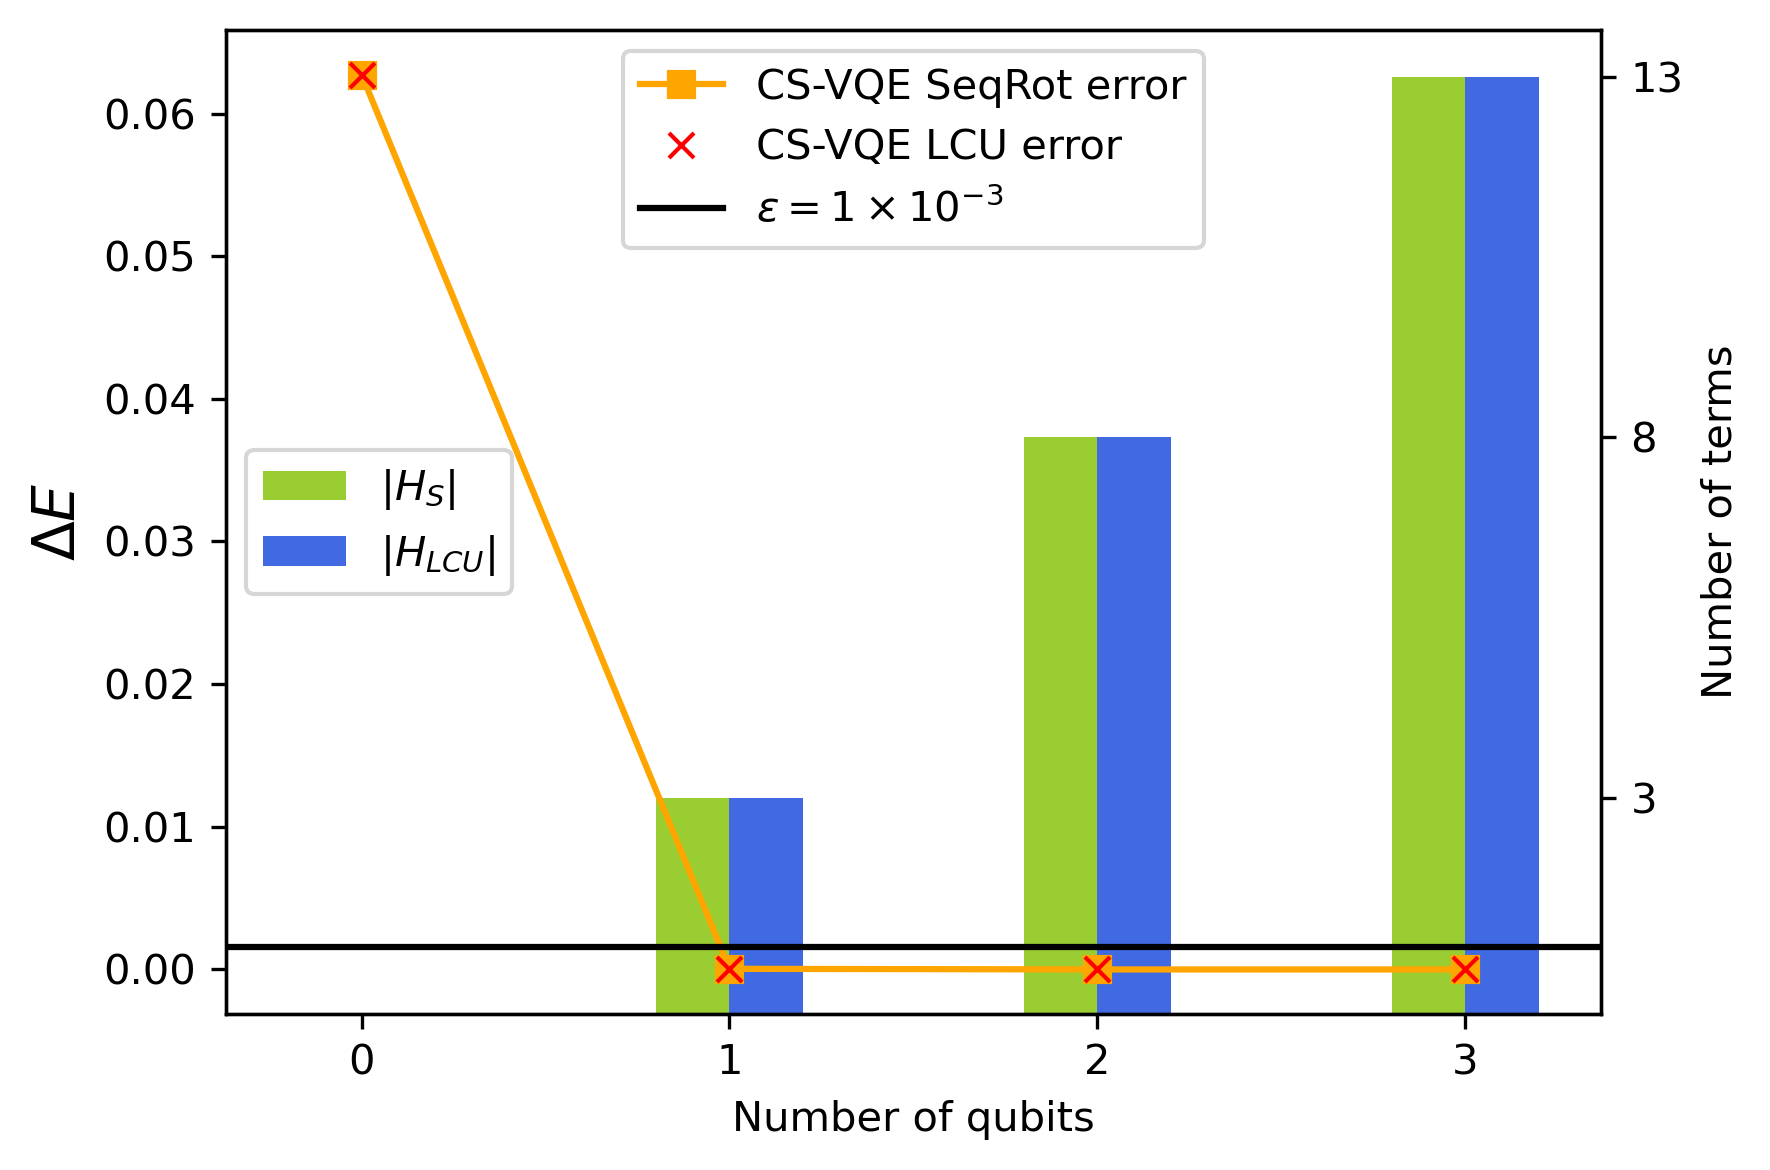

In [587]:
dpi=300
width = 0.2  # the width of the bars
offset = -0.1 # offset on x axis


fig, ax = plt.subplots(dpi=dpi)

n_qubits = np.array([i for i in range(4)]) # labels
rects1 = ax.bar(n_qubits - (offset+width), H_SeqRot_size, width, label='$|H_{S}|$',color="yellowgreen")
rects2 = ax.bar(n_qubits - offset, H_LCU_size, width, label='$|H_{LCU}|$',color="royalblue")


####  second y axis!    
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(n_qubits,Error_S,color="orange",marker="s", label='CS-VQE SeqRot error')#, markersize=12)
ax2.plot(n_qubits,Error_LCU,color="r",marker="x", linestyle='', label='CS-VQE LCU error')

ax2.set_ylabel("$\Delta E $",color="black",fontsize=14)
ax.set_yticks(np.array(list(range(3,14,5))) )
ax.set_yticklabels(np.array(range(3,14,5)) )

ax2.axhline(y=1.6e-3, color='black', linestyle='-', label=r'$\epsilon=1 \times 10^{-3}$')

    
# change left and right y axis (as want error on LHS as more important!)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")

ax.set_ylabel('Number of terms')
ax.set_xlabel('Number of qubits')

ax.set_xticks(np.array([i for i in range(4)]) )
ax.set_xticklabels(np.array([i for i in range(4)]) )
fig.tight_layout()

ax.legend(loc = 'center left')
ax2.legend(loc= 'upper center')


fig.savefig('toy_example_plot.png',
            format='png',
            dpi=dpi,
            bbox_inches='tight')
plt.show()

# Experiment

In [96]:
import random
import cs_vqe_with_LCU as c_LCU

In [97]:
def generate_random_H():
    H_keys = ['ZII','IXI','IYI','IZX','IZY','IZZ','ZXI','ZYI','ZZX','ZZY','ZZZ','IIX','IIY','IIZ']
    random_coeffs = [random.uniform(-1,1) for _ in range(len(H_keys))]
    return dict(zip(H_keys, random_coeffs))
# generate_random_H()

In [267]:
Z_list = ['ZII']
G_list = ['ZII', 'IZI']

T_list = ['IIX', 'IIY', 'IIZ', 'IZX', 'IZY', 'IZZ', 'ZZX', 'ZZY', 'ZZZ']
Ci1_list = ['IIX', 'IIY', 'IIZ']

all_mappings = {
                 'IIX': [[], ['IIX'], 1],
                 'IIY': [[], ['IIY'], 1],
                 'IIZ': [[], ['IIZ'], 1],
                 'IZX': [['IZI'], ['IIX'], 1],
                 'IZY': [['IZI'], ['IIY'], 1],
                 'IZZ': [['IZI'], ['IIZ'], 1],
                 'ZII': [['ZII'], [], 1],
                 'ZZX': [['ZII', 'IZI'], ['IIX'], 1],
                 'ZZY': [['ZII', 'IZI'], ['IIY'], 1],
                 'ZZZ': [['ZII', 'IZI'], ['IIZ'], 1]
}

model = [G_list, Ci1_list, all_mappings]
fn_form = c.energy_function_form(nonCon_H, model)

In [102]:
H_con_keys = ['IXI', 'IYI', 'ZXI', 'ZYI']
H_noncon_keys = ['IIX', 'IIY','IIZ', 'IZX','IZY','IZZ','ZII','ZZX','ZZY', 'ZZZ']

In [137]:
N_experiments = 50

SeqRot_results=[]
LCU_results = []
for i in range(N_experiments):
    
    # generate random H
    ham_dict = generate_random_H()
    openF_H = conv_scr.Get_Openfermion_Hamiltonian(ham_dict)
    eig_values, eig_vectors = eigh((qubit_operator_sparse(openF_H, n_qubits=n_qubits)).todense()) # NOT sparse!
    true_gs = min(eig_values)
    
    ham_noncon_dict = {key: ham_dict[key] for key in H_noncon_keys}
    
    # solve noncon problem
    fn_form = c.energy_function_form(ham_noncon_dict, model)
    lowest_eigenvalue, noncon_ground_state_params, _ , _  = c.find_gs_noncon(ham_noncon_dict,
                                                   method = 'differential_evolution',
                                                   model=model,
                                                   fn_form=fn_form) # returns:  best + [model, fn_form]
    
    # SeqRot
    exp_SeqRot = c.csvqe_approximations_heuristic(ham_dict, ham_noncon_dict, n_qubits, true_gs)
    order_copy = deepcopy(exp_SeqRot[-1])
    SeqRot_reduced_H = c.get_reduced_hamiltonians(ham_dict,
                                        model,
                                        fn_form,
                                        noncon_ground_state_params,
                                        order_copy)
#     SeqRot_results.append({'exp': exp_SeqRot,
#                            'reduced_H': SeqRot_reduced_H} )
    SeqRot_results.append({'exp': exp_SeqRot,
                           'reduced_H_size': [len(H_red)-1 for H_red in SeqRot_reduced_H ]} )
    
    ## LCU
    exp_LCU = c_LCU.csvqe_approximations_heuristic_LCU(ham_dict, ham_noncon_dict, n_qubits, true_gs)
    order_copy2 = deepcopy(exp_LCU[-1])
    LCU_reduced_H = c_LCU.get_reduced_hamiltonians_LCU(ham_dict,
                                        model,
                                        fn_form,
                                        noncon_ground_state_params,
                                        order_copy2)
#     LCU_results.append({'exp': exp_LCU,
#                         'reduced_H': LCU_reduced_H} )
    LCU_results.append({'exp': exp_LCU,
                    'reduced_H_size':[len(H_red)-1 for H_red in LCU_reduced_H] } )

    

In [156]:
SeqRot_results[-1]

{'exp': [-2.5621494900605635,
  [-2.1132856107170994,
   -2.3306996241021185,
   -2.5621494900605666,
   -2.5621494900605666],
  [0.44886387934346406,
   0.23144986595844497,
   -3.1086244689504383e-15,
   -3.1086244689504383e-15],
  [1, 2, 0]],
 'reduced_H_size': [0, 3, 8, 13]}

In [157]:
LCU_results[-1]

{'exp': [-2.5621494900605635,
  [-2.11328561073639,
   -2.330699282145538,
   -2.562149490060566,
   -2.5621494900605644],
  [0.44886387932417326,
   0.23145020791502535,
   -2.6645352591003757e-15,
   -8.881784197001252e-16],
  [1, 2, 0]],
 'reduced_H_size': [0, 3, 8, 13]}

In [196]:
E_seqRot_error_array = np.zeros((N_experiments,4))
E_LCU_error_array  = np.zeros_like(E_seqRot_error_array)

Seq_Rot_H_size_Array = np.zeros_like(E_seqRot_error_array)
LCU_H_size_Array = np.zeros_like(E_seqRot_error_array)

ind=0
for SeqRot_result, LCU_result in zip(SeqRot_results, LCU_results):
    
    true_gs_E = SeqRot_result['exp'][0]
    
    # get errors 
    E_seqRot_error_array[ind,:] = np.array(SeqRot_result['exp'][2])
    E_LCU_error_array[ind,:] = np.array(LCU_result['exp'][2])
    
    # get H sizes
    Seq_Rot_H_size_Array[ind,:] = np.array(SeqRot_result['reduced_H_size'])
    LCU_H_size_Array[ind,:] = np.array(LCU_result['reduced_H_size'])
    
#     if (SeqRot_result['reduced_H_size'] != [0, 3, 8, 13]) and (LCU_result['reduced_H_size'] != [0, 3, 8, 13]):
#         print(SeqRot_result['reduced_H_size'])
#         print(LCU_result['reduced_H_size'])
#         raise ValueError()
    
    ind+=1

In [200]:
LCU_H_size_Array

array([[ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  7., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  7., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  3.,  8., 13.],
       [ 0.,  

In [165]:
E_LCU_error_array[:,2]

array([-1.77635684e-15, -8.88178420e-15, -4.44089210e-15,  2.66453526e-15,
        2.22044605e-15, -4.44089210e-15,  6.18477643e-01, -8.88178420e-16,
        8.88178420e-16, -7.54951657e-15,  0.00000000e+00,  3.55271368e-15,
        1.77635684e-15, -1.33226763e-15, -8.88178420e-16, -8.88178420e-16,
       -2.66453526e-15, -8.88178420e-16,  2.27377384e-01, -1.77635684e-15,
        8.88178420e-16,  3.64207446e-01, -8.88178420e-16,  2.88452323e-01,
        8.88178420e-16, -3.10862447e-15, -6.21724894e-15,  2.22044605e-15,
       -8.88178420e-16, -6.66133815e-15, -3.55271368e-15, -1.77635684e-15,
        1.33226763e-15,  0.00000000e+00, -8.88178420e-16, -3.55271368e-15,
       -3.55271368e-15, -4.44089210e-16, -4.44089210e-15,  2.62963875e-01,
       -4.44089210e-16, -2.66453526e-15,  0.00000000e+00, -6.21724894e-15,
        4.44089210e-16,  6.37412134e-02,  1.33226763e-15,  8.88178420e-16,
       -5.77315973e-15, -2.66453526e-15])

In [170]:
np.where(np.abs(E_seqRot_error_array[:,2])>1e-8)

(array([ 6, 18, 21, 23, 39, 45]),)

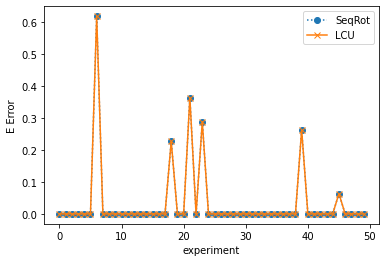

In [199]:
x = range(N_experiments)
plt.plot(x, E_seqRot_error_array[:,2], linestyle='dotted', label='SeqRot', marker='o')
plt.plot(x, E_LCU_error_array[:,2], label='LCU', marker='x')
plt.ylabel('E Error')
plt.xlabel('experiment')
plt.legend()
plt.show()